In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
import datetime
import pprint

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
'''
基本数据导入
'''

In [9]:
FinDataDf = pd.read_excel('C:/Users/jxjsj/Desktop/全申万II级指数.xlsx').set_index('date')
FinDataDf.columns = [i[:-4] for i in FinDataDf.columns]
FinDataReturnDf = FinDataDf.pct_change().dropna()

In [26]:
## 板块
Class = FinDataDf.columns.tolist()

In [11]:
## 周期数据
## 日度
MacroDataDaily = pd.read_excel('C:/Users/jxjsj/Desktop/宏观经济指标.xlsx').dropna()
MacroDataDaily['M'] = MacroDataDaily['中债国债到期收益率:1年']
MacroDataDaily['C'] = MacroDataDaily['中债企业债到期收益率(AA):3年'] - MacroDataDaily['中债企业债到期收益率(AAA):3年']
## 日期调整 - 月末数据取股票交易日月末
stocktest = pd.read_excel('C:/Users/jxjsj/Desktop/券商.xlsx')['date'].tolist()
MacroDataDaily = MacroDataDaily[MacroDataDaily['date'].isin(stocktest)]
## 月度 - 每月最后一天
MacroDataMonthly = MacroDataDaily.copy()
MacroDataMonthly['trade_date'] = MacroDataDaily['date']
MacroDataMonthly = MacroDataMonthly.set_index('date').apply(lambda x: x.resample('M').last()).reset_index()

In [20]:
## 起止时间设定
DataStart = '2007-01-01'
StrategyStart = '2011-01-31'
End = '2019-06-30'

MacroDataMonthlySub = MacroDataMonthly[(MacroDataMonthly['trade_date']>=DataStart) & (MacroDataMonthly['trade_date']<=End)].copy()
FinDataDfSub = FinDataDf[(FinDataDf.index<=End) & (FinDataDf.index>=DataStart)].copy()
FinDataDfSubReturn = FinDataReturnDf[(FinDataReturnDf.index<=End) & (FinDataReturnDf.index>=DataStart)].copy().reset_index()

In [14]:
## 实行策略时点 - 交易日历的月末
MacroDataMonthlySubForStrategy = MacroDataMonthlySub[MacroDataMonthlySub['trade_date']>=StrategyStart]
StrategyDateDf = MacroDataMonthlySubForStrategy[['trade_date']].rename(columns={'trade_date':'StrategyDate'})
StrategyDateList = StrategyDateDf['StrategyDate'].tolist()

In [16]:
## 基准数据导入
BenchmarkIndex = pd.read_excel('C:/Users/jxjsj/Desktop/沪深300.xlsx')
BenchmarkIndex['return'] = BenchmarkIndex['沪深300']/BenchmarkIndex['沪深300'].shift(1)-1
BenchmarkIndexSub = BenchmarkIndex[(BenchmarkIndex['date']>=StrategyStart) & (BenchmarkIndex['date']<=End)]

In [ ]:
'''
策略所需数据/指标/信号计算
'''

In [ ]:
'''
1货币信用周期指标计算
'''

In [17]:
## 货币信用周期指标1 - T~T-3正负占比
def MoneyCredit1(series):
    MList = series.tolist()
    MResultTmp = []
    for i in range(len(MList)-1):
        if MList[-1]-MList[i]>=0:
            MResultTmp.append(1)
        else:
            MResultTmp.append(-1)
    MResult = np.sum(MResultTmp)
    return MResult
def MoneyCredit2(series):
    MList = series.tolist()
    MResultTmp = []
    MResult = MList[-1] - MList[-2]
    return MResult
def MoneyCredit3(series):
    MList = series.tolist()
    MResultTmp = []
    MResult = (MList[-1] + MList[-2]) - (MList[-3] + MList[-4])
    return MResult
MacroDataMonthlySub['DeltaC'] = MacroDataMonthlySub['C'].rolling(4).apply(MoneyCredit1,raw=True)
MacroDataMonthlySub['DeltaM'] = MacroDataMonthlySub['M'].rolling(4).apply(MoneyCredit1,raw=True)
def MCcycle(df):
    if df['DeltaC']>0:
        C='R'
    else:
        C='E'
    if df['DeltaM']>0:
        M='R'
    else:
        M='E'
    return 'M'+M+' C'+C
MacroDataMonthlySub['MCcycle'] = MacroDataMonthlySub.apply(lambda x: MCcycle(x),axis=1)
MCcycleDf = MacroDataMonthlySub[['trade_date','MCcycle']]

In [18]:
'''
2周期表示
'''
CycleList = ['ME CE','ME CR','MR CR','MR CE']

In [ ]:
'''
3各周期与对应月的收益数据合并
'''

In [23]:
## 月收益率
FinDataDfSubClose = FinDataDfSub.copy()
FinDataDfSubClose['trade_date'] = FinDataDfSubClose.index
FinDataDfSubReturnM = FinDataDfSubClose.apply(lambda x: x.resample('M').last()).set_index('trade_date').pct_change().reset_index().dropna()

## 收益率与周期合并
CycleAndReturn = FinDataDfSubReturnM.merge(MCcycleDf,on=['trade_date'],how='left')

In [ ]:
'''
4各板块历史排名滚动平均值计算
'''

In [28]:
RollingMonth = 48

# 计算排名序号，按收益率从大到小排序
def RankCompute(df):
    df = df.copy()
    trade_date = df['trade_date'].tolist()[0]
    dfSub = df[Class]
    tmpDf = dfSub.T
    tmpcol = tmpDf.columns.tolist()[0]
    tmpDf0 = tmpDf.sort_values(tmpcol,ascending=False)
    tmpDf0[tmpcol] = range(1,len(Class)+1)
    tmpDf1 = tmpDf0.T[Class]
    tmpDf1.index = [trade_date]
    return tmpDf1

# 并行计算函数
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst,sort=False)

# 全周期下历史平均排名
RollingRankAllDf = pd.DataFrame()
for StrategyDate in StrategyDateList:
    CycleAndReturnSub = CycleAndReturn[CycleAndReturn['trade_date']<=StrategyDate].copy()
    CycleAndReturnSub = CycleAndReturnSub.iloc[-RollingMonth:,:]
    # 并行计算
    RollingRankGroupby = CycleAndReturnSub.groupby('trade_date')
    RollingRankMaterial = applyParallel(RollingRankGroupby, RankCompute)
    
#     RollingRankMaterial.index = RollingRankMaterial.index.droplevel(1)
    RollingRank = RollingRankMaterial.mean().to_frame().T
    RollingRank.index = [StrategyDate]
    RollingRankAllDf = pd.concat([RollingRankAllDf,RollingRank],axis=0)
RollingRankAllDf.columns = [i+'RankAll' for i in RollingRankAllDf.columns]

# 当前周期的历史同周期平均排名
RollingRankCycleDf = pd.DataFrame()
for StrategyDate in StrategyDateList:
    CycleAndReturnSub = CycleAndReturn[CycleAndReturn['trade_date']<=StrategyDate].copy()
    CycleAndReturnSub = CycleAndReturnSub.iloc[-RollingMonth:,:]
    CycleNow = CycleAndReturnSub['MCcycle'].tolist()[-1]
    CycleAndReturnSub = CycleAndReturnSub[CycleAndReturnSub['MCcycle']==CycleNow]
    # 并行计算
    RollingRankGroupby = CycleAndReturnSub.groupby('trade_date')
    RollingRankMaterial = applyParallel(RollingRankGroupby, RankCompute)
    
#     RollingRankMaterial.index = RollingRankMaterial.index.droplevel(1)
    RollingRank = RollingRankMaterial.mean().to_frame().T
    RollingRank.index = [StrategyDate]
    RollingRankCycleDf = pd.concat([RollingRankCycleDf,RollingRank],axis=0)
RollingRankCycleDf.columns = [i+'RankCycle' for i in RollingRankCycleDf.columns]

In [ ]:
'''
5排名+周期+月度+收益率拼接 - 底稿
'''

In [29]:
AllDataForBackTest = CycleAndReturn.merge(RollingRankCycleDf.merge(RollingRankAllDf,left_index=True,right_index=True),left_on='trade_date',right_index=True,how='left')

In [ ]:
'''
回测部分
'''

In [ ]:
'''
回测函数
'''

In [69]:
### 策略函数
def Strategy(df,HowRank,RankN,cycle_now,history_trade_data):
    '''
    输入当天底稿数据，最终排名方法（偏离度排名，绝对排名），取前几名
    输出所有资产对应目标权重
    '''
    df_ = df.copy()
    if HowRank == '偏离度排名':
        for EachClass in Class:
            df_[EachClass] = df_[EachClass+'RankAll'] - df_[EachClass+'RankCycle']
            # 越大排名靠前
            ascending=False
    if HowRank == '绝对排名':
        for EachClass in Class:
            df_[EachClass] = df_[EachClass+'RankCycle']
            # 越小排名靠前
            ascending=True
    ResultDf = df_[Class].T
    ResultDf = ResultDf.sort_values(ResultDf.columns[0],ascending=ascending)
    ResultDf[ResultDf.columns[0]] = range(1,len(Class)+1)
    # 等风险
    ResultDf = ResultDf.merge(history_trade_data.copy().std().to_frame('std'),left_index=True,right_index=True,how='left')
    ResultDf[ResultDf.columns[0]] = ResultDf.apply(lambda x: 1/x['std'] if x[ResultDf.columns[0]]<=RankN else 0,axis=1)
    ResultDf[ResultDf.columns[0]] = ResultDf[ResultDf.columns[0]]/ResultDf[ResultDf.columns[0]].sum()
    # 等权
#     ResultDf[ResultDf.columns[0]] = ResultDf[ResultDf.columns[0]].apply(lambda x: 1/RankN if x<=RankN else 0)
    
    expected_stock_weight = ResultDf[[ResultDf.columns[0]]].T[Class]
    return expected_stock_weight

In [134]:
### 结算函数 - 月度结算
def Clear(df,tol_equity,expected_stock_weight,cycle):
    '''
    输入下一个月数据，要包含本月最后一天（用以计算收益率）、结算前净值（初始值为1）、目标权重、当前周期
    输出下一个月净值序列（月初-月末）
    '''
    df_ = df.copy()
    expected_stock_w = expected_stock_weight.copy()
    
    # 相对增长 Pt/Pt-1 序列
    df_ = df_[Class]
    df_ = df_.pct_change().dropna()
    df_ = df_+1
    
    # 空仓策略，增长均为1
    if cycle == 'ME CR':
        for df_col in df_.columns:
            df_[df_col] = 1
    
    # 初始净值分配到各个资产上，乘以累计相对增长得到净值序列，丢弃首行拼接  
    stock_w = expected_stock_w.apply(lambda x: x*tol_equity)

    equity_tmp = pd.concat([stock_w,df_],axis=0,sort=False)
    equity_df = equity_tmp.cumprod().sum(axis=1).to_frame('equity_series').iloc[1:,]
    
    return equity_df, equity_df['equity_series'][-1]

In [135]:
### 分析函数 - 计算各类指标
def Indicator(equity_df):
    '''
    输入净值序列，列名equity_series，index为日期
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    df['return'] = df['equity_series']/df['equity_series'].shift(1)-1
    df['drawdown'] = 1-df['equity_series']/df['equity_series'].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df['equity_series'][-1]/df['equity_series'][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 最大回撤时间
#     end_max_drawdown = df['drawdown'].idxmax()
#     df_sub = df[df.index<=end_max_drawdown]
#     start_max_drawdown = df_sub[df_sub['drawdown']==0].index[-1]
#     end_max_drawdown = datetime.datetime.strptime(end_max_drawdown,'%Y-%m-%d')
#     start_max_drawdown = datetime.datetime.strptime(start_max_drawdown,'%Y-%m-%d')
#     max_drawdown_day = (end_max_drawdown - start_max_drawdown).days
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = df['return'].mean()*252
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
#     sharpe_ratio = (mean_return-rf)/vol_return
    # 每年收益率
    df_equity = df[['equity_series']].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={'equity_series':HowRank+str(RankN)})

    output_dict = {
                   'max_drawdown':[max_drawdown],
                   'mean_return':[mean_return],
                   'vol_return':[vol_return],
                   'IR':[IR],
                   'mean_return_max_drawdown_ratio':[mean_return_max_drawdown_ratio],
                  }
    output_df = pd.DataFrame(output_dict,index=[HowRank+str(RankN)]).T
    return output_df, df, df_return_per_year

In [136]:
'''
回测调参
'''

'\n回测调参\n'

In [137]:
## 回测 - 调参

AllResultSaveDfIndicator = pd.DataFrame()
AllResultSaveDfYearReturn = pd.DataFrame()
EquitySeriesDict = {}
WeightDict = {}
# for HowRank in ['偏离度排名','绝对排名']:
for HowRank in ['偏离度排名']:
    for RankN in list(range(5,10)):
        # 初始化指标
        tol_equity = 1
        HowRank = HowRank
        RankN = RankN
        WeightDf = pd.DataFrame()
        equity_df = pd.DataFrame([1],columns=['equity_series'],index=[StrategyDateList[0]])
        # 月末循环执行策略，最后一个月不执行策略
        for cnt in range(len(StrategyDateList)-1):

            # 获取关键日期
            strategy_date = StrategyDateList[cnt]
            next_strategy_date = StrategyDateList[cnt+1]

            # 读取数据 - 历史策略用数据+未来一个月收益率计算数据
            # 历史策略用数据
            history_data = AllDataForBackTest[AllDataForBackTest['trade_date'] == strategy_date]
            history_trade_data = FinDataDfSubReturn[FinDataDfSubReturn['date'] <= strategy_date].iloc[-252:,:]
            cycle_now = history_data['MCcycle'].tolist()[0]

            # 读取数据 - 未来一个月收益率计算数据 
            future_data_for_return = FinDataDf[(FinDataDf.index<=next_strategy_date) & (FinDataDf.index>=strategy_date)]

            # 运行策略
            expected_weight_df = Strategy(history_data, HowRank, RankN, cycle_now,history_trade_data)
            expected_weight_df_output = expected_weight_df.copy()
            expected_weight_df_output.index = [next_strategy_date]
            WeightDf = pd.concat([WeightDf,expected_weight_df_output],axis=0)

            # 结算策略，更新净值
            clear_df, tol_equity = Clear(future_data_for_return,tol_equity,expected_weight_df,cycle_now)

            # 输出净值序列
            equity_df = pd.concat([equity_df,clear_df],axis=0)

        backtest = Indicator(equity_df)
        # 策略结果
        AllResultSaveDfIndicator = pd.concat([AllResultSaveDfIndicator,backtest[0]],axis=1)
        AllResultSaveDfYearReturn = pd.concat([AllResultSaveDfYearReturn,backtest[2]],axis=1)
        EquitySeriesDict[HowRank+str(RankN)] = backtest[1][['equity_series']]
        WeightDict[HowRank+str(RankN)] = WeightDf

In [138]:
'''
与基准比较
'''

'\n与基准比较\n'

In [139]:
# 基准表现计算
# 沪深300指数
BenchmarkIndexSubEquity = BenchmarkIndexSub.rename(columns={'沪深300':'equity_series'}).set_index('date')[['equity_series']]
BenchmarkIndexSubEquityFirst = BenchmarkIndexSubEquity['equity_series'].tolist()[0]
BenchmarkIndexSubEquity['equity_series'] = BenchmarkIndexSubEquity['equity_series'].apply(lambda x: x/BenchmarkIndexSubEquityFirst)

ResultIndex1 = Indicator(BenchmarkIndexSubEquity)[0].rename(columns={Indicator(BenchmarkIndexSubEquity)[0].columns[0]:'沪深300'})
ResultIndex2 = Indicator(BenchmarkIndexSubEquity)[2].rename(columns={Indicator(BenchmarkIndexSubEquity)[2].columns[0]:'沪深300'})
AllResultSaveDfIndicator = pd.concat([AllResultSaveDfIndicator,ResultIndex1],axis=1)
AllResultSaveDfYearReturn = pd.concat([AllResultSaveDfYearReturn,ResultIndex2],axis=1)

In [140]:
'''
全回测结果输出
'''

'\n全回测结果输出\n'

In [141]:
# 指标/年度收益结果输出
# AllResultSaveDfIndicator.T.to_excel('C:/Users/jxjsj/Desktop/资产配置课题/AllResultSaveDfIndicator.xlsx',index=True)
# AllResultSaveDfYearReturn.to_excel('C:/Users/jxjsj/Desktop/资产配置课题/AllResultSaveDfYearReturn.xlsx',index=True)

# 净值序列输出
# 策略
AllEquityDf = pd.DataFrame()
for key in EquitySeriesDict.keys():
#     EquitySeriesDict[key].to_excel('C:/Users/jxjsj/Desktop/资产配置课题/' + key + '.xlsx',index=True)
    EquitySeries = EquitySeriesDict[key].rename(columns={'equity_series':key})
    AllEquityDf = pd.concat([AllEquityDf,EquitySeries],sort=False,axis=1)
# 指数
IndexSubEquity = Indicator(BenchmarkIndexSubEquity)[1][['equity_series']].rename(columns={'equity_series':'中证金融地产'})
AllEquityDf = pd.concat([AllEquityDf,IndexSubEquity],sort=False,axis=1)

# 周期序列输出（日度）
DummyCycleDataM = pd.get_dummies(AllDataForBackTest[['trade_date','MCcycle']].set_index('trade_date'))
DummyCycleDataD = backtest[1][['equity_series']].merge(DummyCycleDataM,left_index=True,right_index=True,how='left').fillna(method='bfill')[DummyCycleDataM.columns.tolist()]
# DummyCycleDataD.to_excel('C:/Users/jxjsj/Desktop/资产配置课题/DummyCycleDataD.xlsx',index=True)

# 周期图表
CycleMC = DummyCycleDataD.merge(MacroDataDaily,left_index=True,right_on='date',how='left').set_index('date')
# CycleMC.to_excel('C:/Users/jxjsj/Desktop/资产配置课题/CycleMC.xlsx',index=True)

# 底稿数据输出（月度）
# AllDataForBackTest.to_excel('C:/Users/jxjsj/Desktop/资产配置课题/AllDataForBackTest.xlsx',index=False)

# 权重数据输出
for key in WeightDict:
    WeightDfEach = WeightDict[key][Class]
#     WeightDfEach.to_excel('C:/Users/jxjsj/Desktop/资产配置课题/' + key + 'Weight.xlsx',index=True)

In [142]:
AllResultSaveDfIndicator.T

,max_drawdown,mean_return,vol_return,IR,mean_return_max_drawdown_ratio
偏离度排名5,0.393624,0.169902,0.223638,0.759722,0.431636
偏离度排名6,0.396838,0.159872,0.220616,0.724661,0.402864
偏离度排名7,0.400648,0.173661,0.218727,0.793964,0.433451
偏离度排名8,0.398990,0.167479,0.216888,0.772191,0.419756
偏离度排名9,0.392692,0.167343,0.215217,0.777557,0.426144
沪深300,0.466961,0.054227,0.233261,0.232476,0.116128


In [143]:
AllResultSaveDfYearReturn

,偏离度排名5,偏离度排名6,偏离度排名7,偏离度排名8,偏离度排名9,沪深300
date,,,,,,
2011-12-31,-0.055231,-0.058716,-0.054474,-0.058788,-0.063226,-0.237531
2012-12-31,0.081466,0.056533,0.069708,0.057073,0.051349,0.075545
2013-12-31,0.312692,0.335079,0.317660,0.294395,0.298136,-0.076468
2014-12-31,0.662973,0.615949,0.623996,0.603368,0.567451,0.516595
2015-12-31,0.301512,0.286337,0.344816,0.334324,0.369311,0.055834
2016-12-31,0.191067,0.188058,0.196784,0.186209,0.189669,-0.112818
2017-12-31,-0.105491,-0.106974,-0.089003,-0.058332,-0.045192,0.217751
2018-12-31,-0.160985,-0.173527,-0.160874,-0.162778,-0.164764,-0.253098
2019-12-31,0.245700,0.238101,0.262613,0.245128,0.234600,0.270683


In [144]:
'''
按照全净值序列数据 计算相对基准胜率并输出（需要关联周期序列表，日度净值可以自动降为月度数据）
'''

'\n按照全净值序列数据 计算相对基准胜率并输出（需要关联周期序列表，日度净值可以自动降为月度数据）\n'

In [145]:
AllEquityDf_ = AllEquityDf.copy()
CycleMat = AllDataForBackTest[['trade_date','MCcycle']].set_index('trade_date').copy()
def ComputeWinOfCycle(df):
    win_time = df['equity_win'].sum()
    win = win_time/len(df)
    return win

def ResampleCycleTrade(df):
    df = df.copy()
    ResampleWinDf = pd.DataFrame()
    df['Cycle_Pos'] = df['MCcycle'] + df['Positon']
    for cnt in range(1,len(df)):
        date = df.index[cnt-1]
        Cycle_Pos = df.iloc[cnt,:]['Cycle_Pos']
        SubDfForComputeWin = df.iloc[cnt-1,:].to_frame(date).T
        if Cycle_Pos != df.iloc[cnt-1,:]['Cycle_Pos']:
            ResampleWinDf = pd.concat([ResampleWinDf,SubDfForComputeWin],axis=0)
    return ResampleWinDf

def ComputeWinEachCycle(df):
    TradeTime = 0
    for cnt in range(len(df)):
        NowDf = df.iloc[cnt,:]
        if cnt == 0:
            NowCycle = NowDf['MCcycle']
            NowPosition = NowDf['Position']
            LastEquity = 1
            continue
        if NowDf['MCcycle'] != NowCycle:
            TradeTime += 1

# 按照周期和持仓变化作为一次交易，计算胜率
# AllWinResult = pd.DataFrame()
# for asset in [i for i in AllEquityDf_.columns if i not in ['中证金融地产','工银瑞信金融地产']]:
#     EquityDf_ = AllEquityDf_[[asset]]
#     WeightDf_ = WeightDict[asset]
#     WeightDf_['Positon'] = WeightDf_.apply(lambda x: str(x['券商'])+str(x['银行'])+str(x['房地产'])+str(x['保险']),axis=1)
    
#     # 净值数据匹配周期数据、持仓数据
#     DfForComputeWin = CycleMat.merge(EquityDf_,left_index=True,right_index=True,how='left').merge(WeightDf_,left_index=True,right_index=True,how='left')
#     # 重采样
#     DfForComputeWin_ = ResampleCycleTrade(DfForComputeWin)
    
#     # 计算每个 周期-交易 内的收益率
#     DfForComputeWin_['equity_return'] = DfForComputeWin_[asset].pct_change()
#     DfForComputeWin_['equity_return'] = DfForComputeWin_['equity_return'].fillna(DfForComputeWin_[asset]-1)
#     DfForComputeWin_['equity_win'] = DfForComputeWin_['equity_return'].apply(lambda x: 1 if x>0 else 0)
#     WinResult = DfForComputeWin_.groupby('MCcycle').apply(ComputeWinOfCycle).to_frame(asset)

#     # 输出
#     AllWinResult = pd.concat([AllWinResult,WinResult],axis=1)
# AllWinResult.to_excel('C:/Users/jxjsj/Desktop/资产配置课题/AllWinResult.xlsx',index=True)

# 每个月调仓或者再平衡作为一次交易，计算相对中证金融地产胜率
AllWinResult = pd.DataFrame()
for asset in [i for i in AllEquityDf_.columns if i not in ['中证金融地产']]:
    EquityDf_ = (AllEquityDf_[asset]/AllEquityDf_['中证金融地产']).to_frame(asset)

    # 净值数据匹配周期数据
    DfForComputeWin_ = CycleMat.merge(EquityDf_,left_index=True,right_index=True)
    
    # 计算每个 周期-交易 内的收益率
    DfForComputeWin_['equity_return'] = DfForComputeWin_[asset].pct_change()
    DfForComputeWin_ = DfForComputeWin_.dropna()
    DfForComputeWin_['equity_return'] = DfForComputeWin_['equity_return'].fillna(DfForComputeWin_[asset]-1)
    DfForComputeWin_['equity_win'] = DfForComputeWin_['equity_return'].apply(lambda x: 1 if x>0 else 0)
    WinResult = DfForComputeWin_.groupby('MCcycle').apply(ComputeWinOfCycle).to_frame(asset)
    
    # 计算全周期下收益
    WinResultTmp = pd.DataFrame([ComputeWinOfCycle(DfForComputeWin_)],index=['AllCycle'],columns=[asset])
    WinResult = pd.concat([WinResult,WinResultTmp],axis=0)

    # 输出
    AllWinResult = pd.concat([AllWinResult,WinResult],axis=1)
# AllWinResult.to_excel('C:/Users/jxjsj/Desktop/资产配置课题/AllWinResult.xlsx',index=True)

In [146]:
AllWinResult

,偏离度排名5,偏离度排名6,偏离度排名7,偏离度排名8,偏离度排名9
ME CE,0.680000,0.680000,0.640000,0.640000,0.600000
ME CR,0.571429,0.476190,0.476190,0.428571,0.476190
MR CE,0.517241,0.551724,0.551724,0.551724,0.517241
MR CR,0.576923,0.576923,0.615385,0.538462,0.615385
AllCycle,0.584158,0.574257,0.574257,0.544554,0.554455


In [36]:
'''
最优结果输出&绘图
'''

'\n最优结果输出\n'

In [147]:
## 回测 - 最优结果

# 初始化指标
tol_equity = 1
HowRank = '偏离度排名'
RankN = 7
WeightDf = pd.DataFrame()
equity_df = pd.DataFrame([1],columns=['equity_series'],index=[StrategyDateList[0]])
# 月末循环执行策略，最后一个月不执行策略
for cnt in range(len(StrategyDateList)-1):

    # 获取关键日期
    strategy_date = StrategyDateList[cnt]
    next_strategy_date = StrategyDateList[cnt+1]

    # 读取数据 - 历史策略用数据+未来一个月收益率计算数据
    # 历史策略用数据
    history_data = AllDataForBackTest[AllDataForBackTest['trade_date'] == strategy_date]
    history_trade_data = FinDataDfSubReturn[FinDataDfSubReturn['date'] <= strategy_date].iloc[-252:,:]
    cycle_now = history_data['MCcycle'].tolist()[0]

    # 读取数据 - 未来一个月收益率计算数据 
    future_data_for_return = FinDataDf[(FinDataDf.index<=next_strategy_date) & (FinDataDf.index>=strategy_date)]

    # 运行策略
    expected_weight_df = Strategy(history_data, HowRank, RankN, cycle_now,history_trade_data)
    expected_weight_df_output = expected_weight_df.copy()
    expected_weight_df_output.index = [next_strategy_date]
    WeightDf = pd.concat([WeightDf,expected_weight_df_output],axis=0)

    # 结算策略，更新净值
    clear_df, tol_equity = Clear(future_data_for_return,tol_equity,expected_weight_df,cycle_now)

    # 输出净值序列
    equity_df = pd.concat([equity_df,clear_df],axis=0)

backtest = Indicator(equity_df)
# 策略结果
AllResultSaveDfIndicator = pd.concat([AllResultSaveDfIndicator,backtest[0]],axis=1)
AllResultSaveDfYearReturn = pd.concat([AllResultSaveDfYearReturn,backtest[2]],axis=1)
EquitySeriesDict[HowRank+str(RankN)] = backtest[1][['equity_series']]
WeightDict[HowRank+str(RankN)] = WeightDf

# 策略结果
# print('Strategy')
# print(backtest[0])
# print(backtest[2])
# backtest[1].to_excel('C:/Users/jxjsj/Desktop/资产配置课题/bestbacktest.xlsx',index=True)

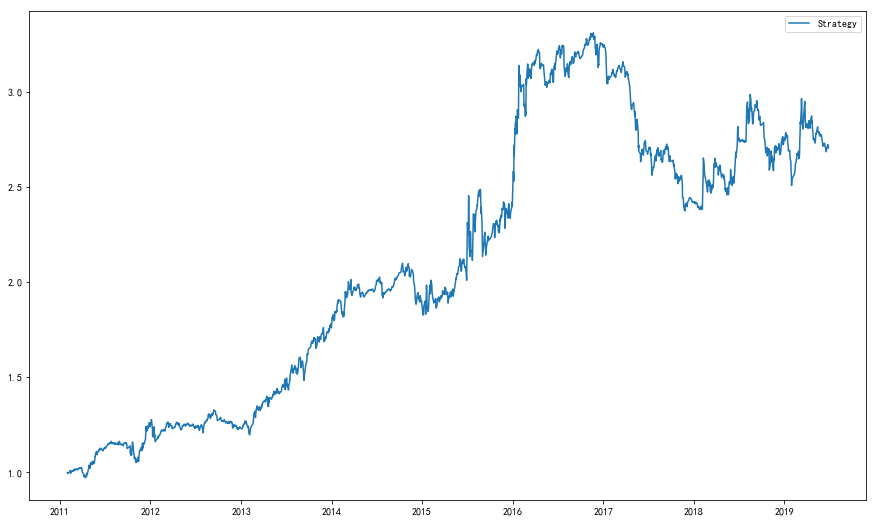

In [148]:
# 超额净值
plt.figure(figsize=(15,9))
plt.plot(backtest[1][['equity_series']]/BenchmarkIndexSubEquity[['equity_series']],label='Strategy')
# plt.plot(BenchmarkFundSubEquity[['equity_series']]/BenchmarkIndexSubEquity[['equity_series']],label='Fund')
# plt.plot(BenchmarkIndexSubEquity[['equity_series']],label='Index')
plt.legend(loc=0)

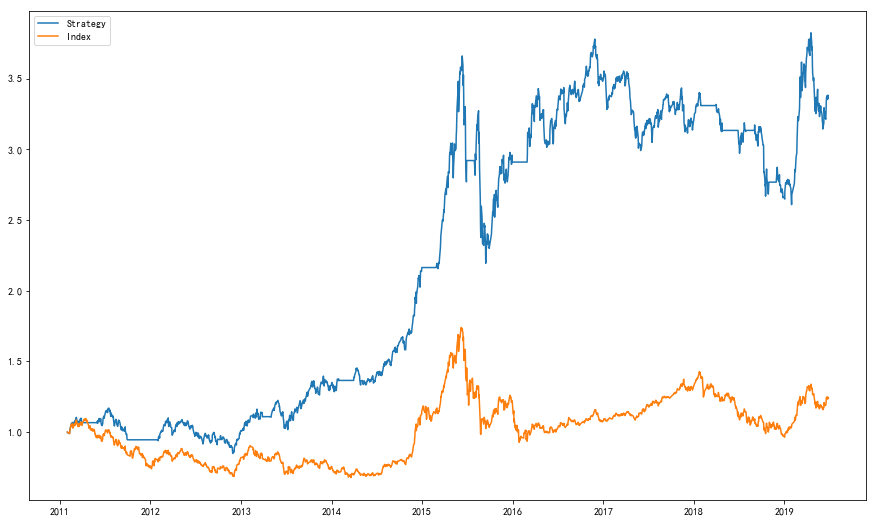

In [149]:
# 绝对净值
plt.figure(figsize=(15,9))
plt.plot(backtest[1][['equity_series']],label='Strategy')
# plt.plot(BenchmarkFundSubEquity[['equity_series']],label='Fund')
plt.plot(BenchmarkIndexSubEquity[['equity_series']],label='Index')
plt.legend(loc=0)